In [1]:
import numpy as np
import datetime as dt 
import pandas as pd
import pandas_datareader.data as web
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Set date ranges:
# Start date
start = dt.datetime(2018,1,1)
# End date
end = dt.datetime(2020,6,30)

# Set symbol name
symbol_name = 'SP500'

In [3]:
# Dictionary of stock names & their corresponding symbols
symbols = {
    'SP500': '^GSPC',
    'Russell2000': '^RUT',
    'Apple': 'APPL',
    'Microsoft': 'MSFT'
}

# Import data using Pandas Datareader
df = web.DataReader(
        name = symbols[symbol_name], data_source = 'yahoo', 
        start = start, end = end
    )

# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))

High          Low         Open        Close      Volume  \
Date                                                                         
2018-01-02  2695.889893  2682.360107  2683.729980  2695.810059  3367250000   
2020-06-30  3111.510010  3047.830078  3050.199951  3100.290039  4696280000   

              Adj Close  
Date                     
2018-01-02  2695.810059  
2020-06-30  3100.290039  


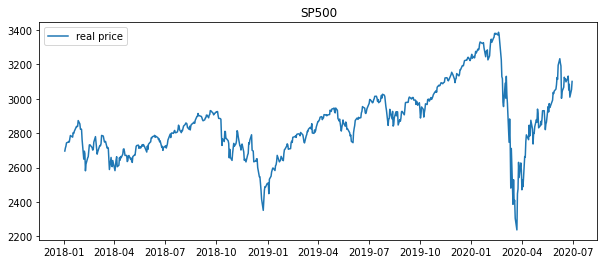

In [4]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='real price')
plt.legend(loc = 'upper left')
plt.show()

Train: 439, Test: 189


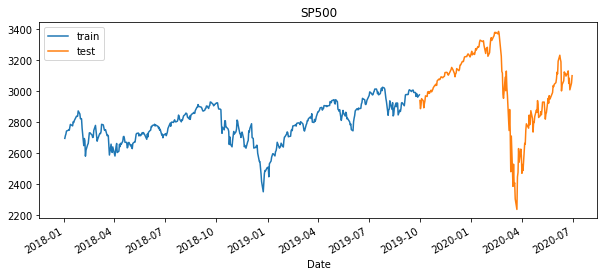

In [5]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Close'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.title('SP500')
ax.legend(loc = 'upper left')
plt.show()

In [6]:
# Calculate volatility
def returns_vol(df, column):
    # Calculate returns as percentage of price changes
    df['Returns'] = df[column].pct_change()*100
    # Calculate daily std of returns
    volatility = df['Returns'].std()
    df.dropna(inplace=True)
    return df, volatility

df, volatility = returns_vol(df, column='Close')

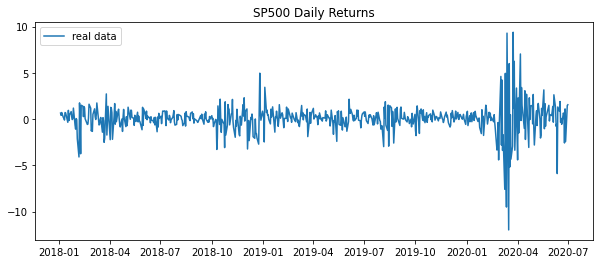

Daily volatility: 1.54% 
Monthly volatility: 7.07% 
Annual volatility: 24.50% 


In [7]:
# Plot the price returns
plt.figure(figsize=(10,4))
plt.plot(df['Returns'], label='real data')
plt.title('SP500 Daily Returns')
plt.legend(loc = 'upper left')
plt.show()

# Print volatility
print(f'''Daily volatility: {volatility:.2f}% 
Monthly volatility: {np.sqrt(21)*volatility:.2f}% 
Annual volatility: {np.sqrt(252)*volatility:.2f}% ''')

In [8]:
# Specify GARCH model function
def garch_model(df, p=1, o=0, q=1, mean='constant', vol = 'GARCH', 
                dist='normal'):
    model = arch_model(
        df, 
        p = p, o=o, q = q, 
        mean = mean,
        vol = vol,
        dist = dist
    )
    return model

In [9]:
# Implement a basic GARCH model
basic_gm = garch_model(df['Returns']) 
# Fit the model
gm_result = basic_gm.fit(disp='off', show_warning=False)

# Display model fitting summary
print(gm_result.summary())

Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -878.696
Distribution:                  Normal   AIC:                           1765.39
Method:            Maximum Likelihood   BIC:                           1783.15
                                        No. Observations:                  627
Date:                Sun, Jul 12 2020   Df Residuals:                      623
Time:                        03:19:07   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1236  3.029e-02      4.081  4.484e-05 [6.424e-02,  0.183]
          

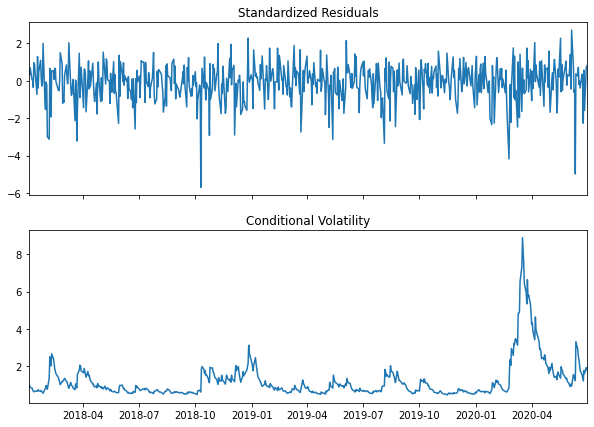

In [10]:
# Plot fitted results
plt.rc("figure", figsize=(10, 7))
gm_result.plot()
plt.show()

In [11]:
# Obtain model estimated residuals and volatility
# Residual = predicted price - real price
gm_resid = gm_result.resid
# Predicted price volatility (std)
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std

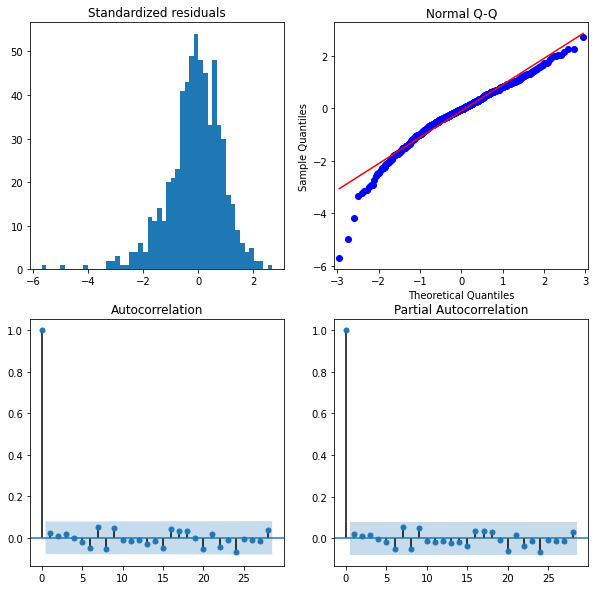

In [12]:
# Diagnose plot of residuals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.hist(gm_std_resid, bins = 50)
ax1.set_title('Standardized residuals')
qqplot(gm_std_resid, line='s', ax=ax2)
ax2.set_title('Normal Q-Q')
plot_acf(gm_std_resid, ax=ax3)
plot_pacf(gm_std_resid, ax=ax4)
plt.show()

In [13]:
# Specify GJR-GARCH model assumptions
gjr_gm = garch_model(df['Returns'], o=1, dist = 'skewt') 

# Fit the model
gjr_result = gjr_gm.fit(disp='off', show_warning=False)

# Get model estimated volatility
gjr_vol = gjr_result.conditional_volatility

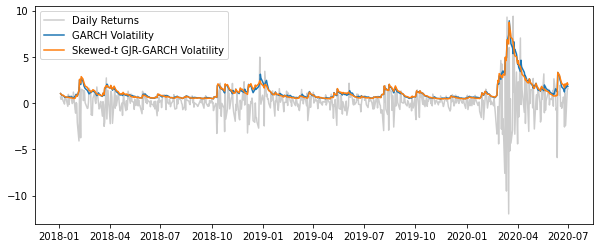

Correlation coef between GARCH & skewed-t GJR=GARCH: 0.99


In [14]:
# Plot model fitting results
plt.rc("figure", figsize=(10, 4))
gm_vol = gm_result.conditional_volatility
plt.plot(df['Returns'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(gm_vol, label = 'GARCH Volatility')
plt.plot(gjr_vol, label = 'Skewed-t GJR-GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()
print(f'Correlation coef between GARCH & skewed-t GJR=GARCH: {round(np.corrcoef(gm_vol, gjr_vol)[0,1],2)}')

In [15]:
# In-sample rolling window one-step-forecast
index = df.index
end_loc = 577
forecasts = {}
for i in range(50):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(last_obs = i + end_loc,
                             disp='off', show_warning=False)
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
# Save all forecast to a dataframe    
forecast_var = pd.DataFrame(forecasts).T

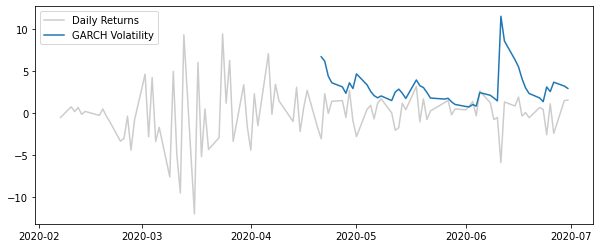

In [16]:
# Plot in-sample forecast and real volatility
plt.plot(df.Returns[-100:], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(forecast_var, label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()

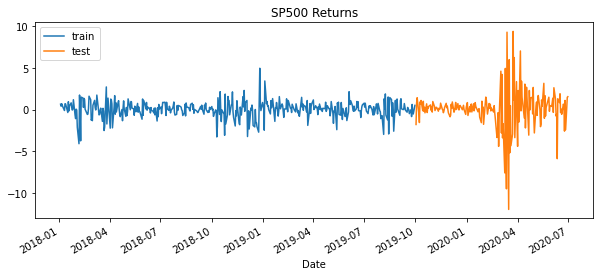

In [17]:
# Now let's try forecast on test date
test = pd.DataFrame(test)
train = pd.DataFrame(train)
train, _ = returns_vol(train, column='Close')
test, _ = returns_vol(test, column='Close')

# Plot train & test returns
fig, ax = plt.subplots(figsize=(10,4))
train['Returns'].plot(ax=ax, label='train')
test['Returns'].plot(ax=ax, label='test')
plt.title('SP500 Returns')
ax.legend(loc = 'upper left')
plt.show()

In [18]:
# Out-of-sample rolling window one-step-forecast
rolling_predictions = []
for i in range(test.shape[0]):
    model = garch_model(train['Returns'], p=1, o=1, q=1)
    model_fit = model.fit(update_freq=1, disp='off')
    pred = model_fit.forecast(horizon=1)
    train = train.append(test.iloc[i])
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

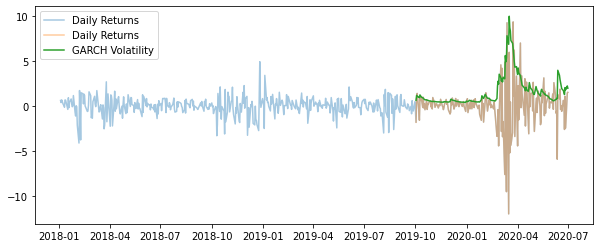

In [19]:
# Plot out-of-sample forecast and real volatility
rolling_predictions = pd.DataFrame(rolling_predictions, index=test.index)
plt.plot(train['Returns'], 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(test['Returns'], 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(rolling_predictions, 
         label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()

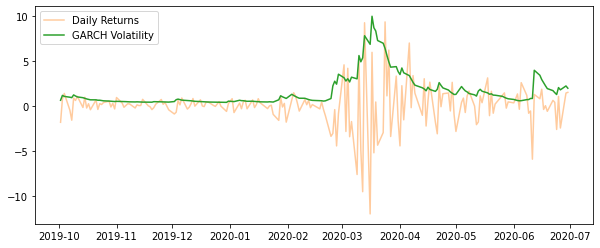

In [20]:
# Plot only test data with forecasted returns
plt.plot(test['Returns'], color = 'C1', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(rolling_predictions, color = 'C2',
         label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()